In [1]:
import pandas as pd
from FastFitClassifier import FastFitClassifier

In [2]:
classifier_type = 'class'

model_path = "./models/avsolatorio/GIST-small-Embedding-v0"
model_path = './models/relevance/avsolatorio/GIST-Embedding-v0'

In [3]:
def import_labelled_data(path="data/labelled/data.json", group_relevant=True):
    data = pd.read_json(path, encoding="latin-1")
    data["relevance"] = data["class"].apply(
        lambda x: "relevant" if x != "irrelevant" else x
    )
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../data/labelled/data.json", group_relevant=False)

# drop null classes
test_dataset = test_dataset.dropna(subset=["class"])

print("Data loaded.")

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)
# test_dataset = test_dataset.sample(250)
# test_dataset = test_dataset.groupby(classifier_type).apply(lambda x: x.sample(125))

test_dataset.info()


Loading data...
Data loaded.


ValueError: Cannot take a larger sample than population when 'replace=False'

In [12]:
test_dataset.index[:10]

MultiIndex([('..',  123),
            ('..',  638),
            ('..', 1580),
            ('..', 1624),
            ('..', 2283),
            ('..', 2432),
            ('..', 2646),
            ('..', 2994),
            ('..', 3299),
            ('..', 3531)],
           names=['class', None])

In [10]:
test_dataset = test_dataset.groupby(classifier_type).apply(lambda x: x,include_groups=True)

ValueError: 'class' is both an index level and a column label, which is ambiguous.

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
classifier = FastFitClassifier(
    model_path=model_path,
    text_overlap_proportion=0.2,
    device='cuda:0'
)

Loading model from ./models/relevance/avsolatorio/GIST-Embedding-v0 ...
Model loaded.
Tokenizer loaded....


The model 'FastFit' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenceClassif


Classifier pipeline built.


Data chunked....


Files	:   0%|          | 0/250 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/10067 [00:00<?, ?it/s]

Calculated predictions.
Evaluating model...

-----------------------------------------------------

Classification Report: 
              precision    recall  f1-score   support

  irrelevant       1.00      1.00      1.00        53
    relevant       1.00      1.00      1.00       197

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

-----------------------------------------------------
Accuracy: 1.0
Precision: 1.0
Specificity: 1.0


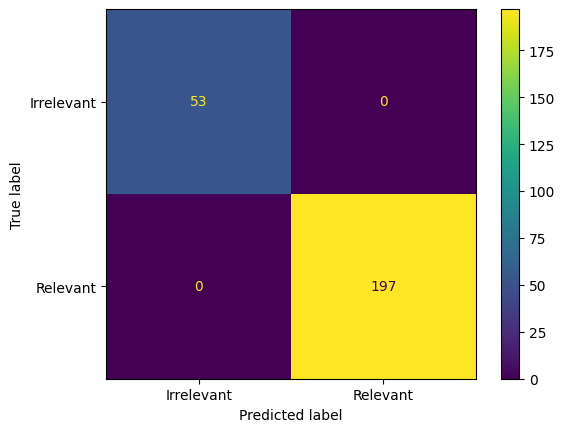

In [ ]:

#! on fastfit/modeling.py, line 838, inserting **kwargs
#! it's easier than getting the tokenizer to stop outputting
#! extra info like token_type_ids

classifier.evaluate(
    test_dataset,
    metrics=[
        "accuracy",
        "precision",
        "classification-report",
        "specificity",
        "confusion-matrix-mpl",
    ],
    aggregate="majority",
)

In [ ]:
t = test_dataset.sample(5)
classifier.predict(t)

Data chunked....


Files	:   0%|          | 0/5 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/221 [00:00<?, ?it/s]

Calculated predictions.


,url,text,class,relevance,predictions
9014,https://www.conservationevidence.com/individua...,"A study in eastern England, UK of the pollinat...",Bee Conservation,relevant,relevant
588,https://www.conservationevidence.com/individua...,(Summarised by: Nick Littlewood)This study is ...,Terrestrial Mammal Conservation,relevant,relevant
3982,http://defendem.com/pdf/our-readiness-for-reso...,Our readiness for resolution NatWest Group 202...,irrelevant,irrelevant,irrelevant
8813,https://www.conservationevidence.com/individua...,Create 'rock pools' on intertidal artificial s...,Biodiversity of Marine Artificial Structures,relevant,relevant
8798,https://www.conservationevidence.com/individua...,"(Summarised by: Maggie Watson, Katie Sainsbury...",Reptile Conservation,relevant,relevant


In [ ]:
t = pd.DataFrame(
    [
        {"text": "Quantifying the effects of Entry Level Stewardship (ELS) on diversity at the scale: The Hillesden Experiment", "class": "relevant"},
        {"text": "The economy in the UK", "class": "irrelevant"},
    ]
)
classifier.predict(t)

Data chunked....


Files	:   0%|          | 0/2 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/2 [00:00<?, ?it/s]

Calculated predictions.


,text,class,predictions
0,Quantifying the effects of Entry Level Steward...,relevant,relevant
1,The economy in the UK,irrelevant,irrelevant
